In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
sys.path.append('../models/stylegan2')
import dnnlib
import dnnlib.tflib as tflib
from run_generator import generate_images
import pretrained_networks
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import torch
import models
import util
import config
import viz
import scipy.stats
import figs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done!


/home/ubuntu/face-disentanglement/src/figs.py:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(R, C, 1)
/home/ubuntu/face-disentanglement/src/figs.py:111: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, 1)


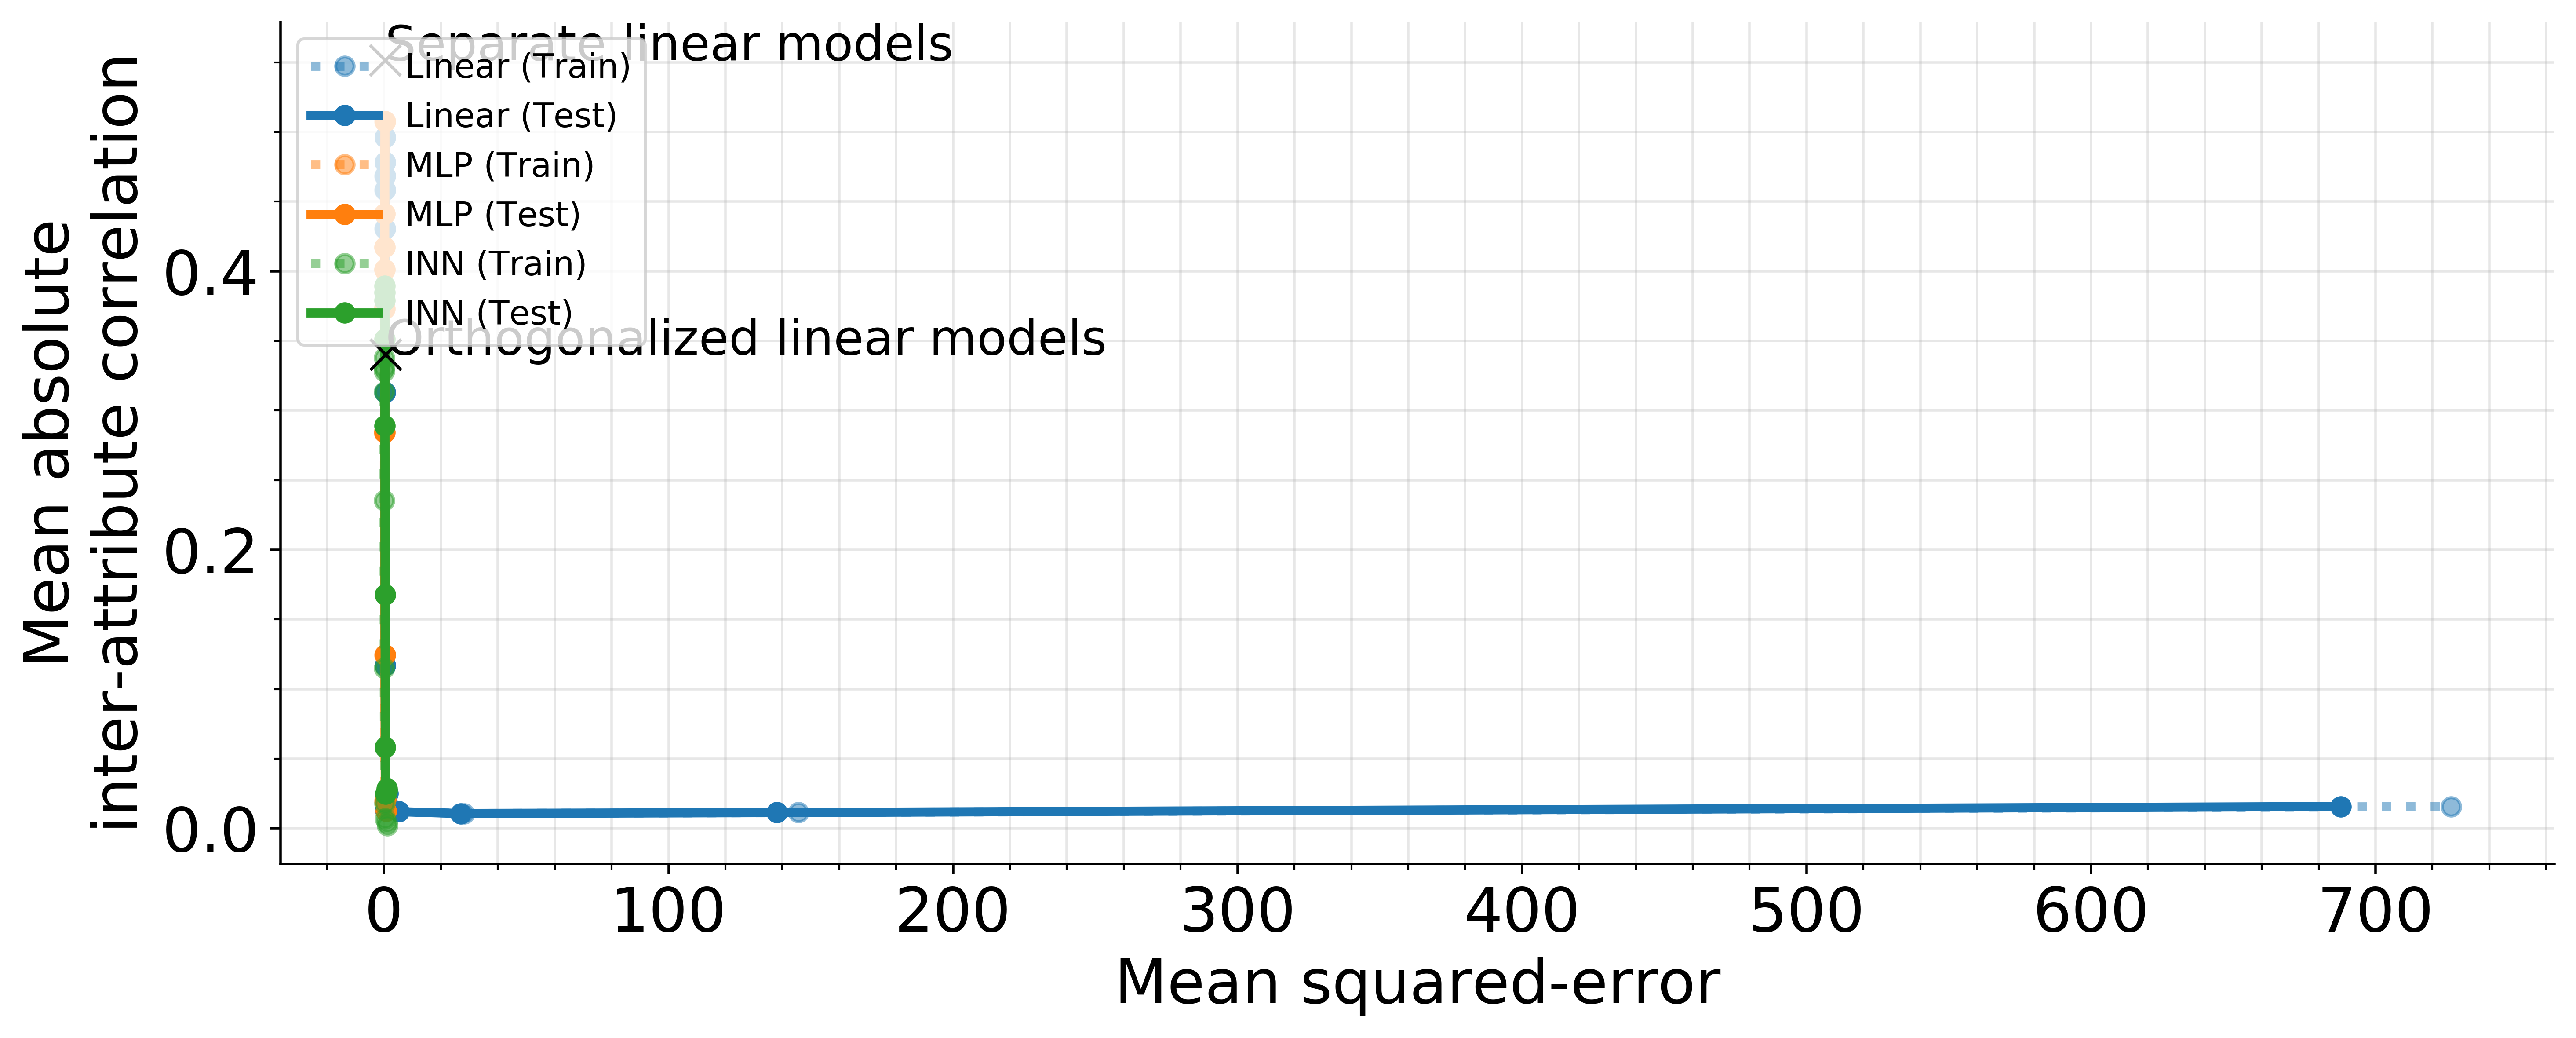

In [37]:
figs.plot_mse_vs_corrs()

# load latent-mapping model

In [3]:
fname = config.BEST_MODEL
df = pd.read_pickle(oj(config.PROCESSED_DIR, fname + '.pkl'))
p = pkl.load(open(oj(config.PROCESSED_DIR, fname + '_params.pkl'), 'rb'))
state_dicts = pkl.load(open(oj(config.PROCESSED_DIR, fname + '_weights.pkl'), 'rb'))

In [4]:
d = df[['epochs', 'mse_test', 'indep_corr_test']].infer_objects().round(2)
d[(d['mse_test'] < 0.5) & (d['indep_corr_test'] < 0.3)]

key_epoch = 10000
state_dict = state_dicts[key_epoch]
device = 'cpu'
LATENT_DIM = 512
m = models.get_INN(num_layers=p['num_layers'], hidden_size=p['hidden_size'],
                   input_size=LATENT_DIM).to(device)
m.load_state_dict(state_dict)

Node 'coupling_0' takes the following inputs:
	 Output #0 of node 'input' with dims (512,)

Node 'coupling_1' takes the following inputs:
	 Output #0 of node 'coupling_0' with dims (512,)

Node 'coupling_2' takes the following inputs:
	 Output #0 of node 'coupling_1' with dims (512,)

Node 'output' takes the following inputs:
	 Output #0 of node 'coupling_2' with dims (512,)



<All keys matched successfully>

# let's start by looking at the distr of the predictions

In [6]:
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))
annotations_dict = pkl.load(open(oj(config.PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(config.PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
annotations_dict_names = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict_names[k]
                    for k in annotations_dict_names}
print(annotations_dict_names)
N_A = len(config.ATTRS)

attr_mat = np.array([annotations_dict[attr].mean(axis=1) for attr in config.ATTRS]).transpose()
def normalize_mat(X):
    '''Normalize columns
    '''
    return (X - X.mean(axis=0)) / X.std(axis=0)

X = latents
Y = np.zeros(latents.shape) # pad Y with zeros, only first N rows have attributes
Y[:, :N_A] = attr_mat
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, Y, test_size=0.3, random_state=42)
preds = util.detach(m(torch.Tensor(X_test)))[:, :N_A]
preds = (preds * attr_mat.std(axis=0)) +  attr_mat.mean(axis=0)

{'ethnicity': ['East Asian', 'South Asian', 'African', 'Latino', 'Middle East', 'Caucasian'], 'age': ['Child', 'Teen', 'Young adult', 'Adult', 'Middle age', 'Senior'], 'gender': ['Female', 'Probably female', 'In between', 'Probably male', 'Male'], 'skin-color': ['Light', 'Fair', 'Medium', 'Olive', 'Brown', 'Black'], 'makeup': ['None', 'Minimal', 'Full', 'Showy'], 'facial-hair': ['None', 'Minimal', 'Mustache', 'Beard', 'Full'], 'hair-length': ['Very short', 'Short', 'Medium', 'Long', 'Very long']}


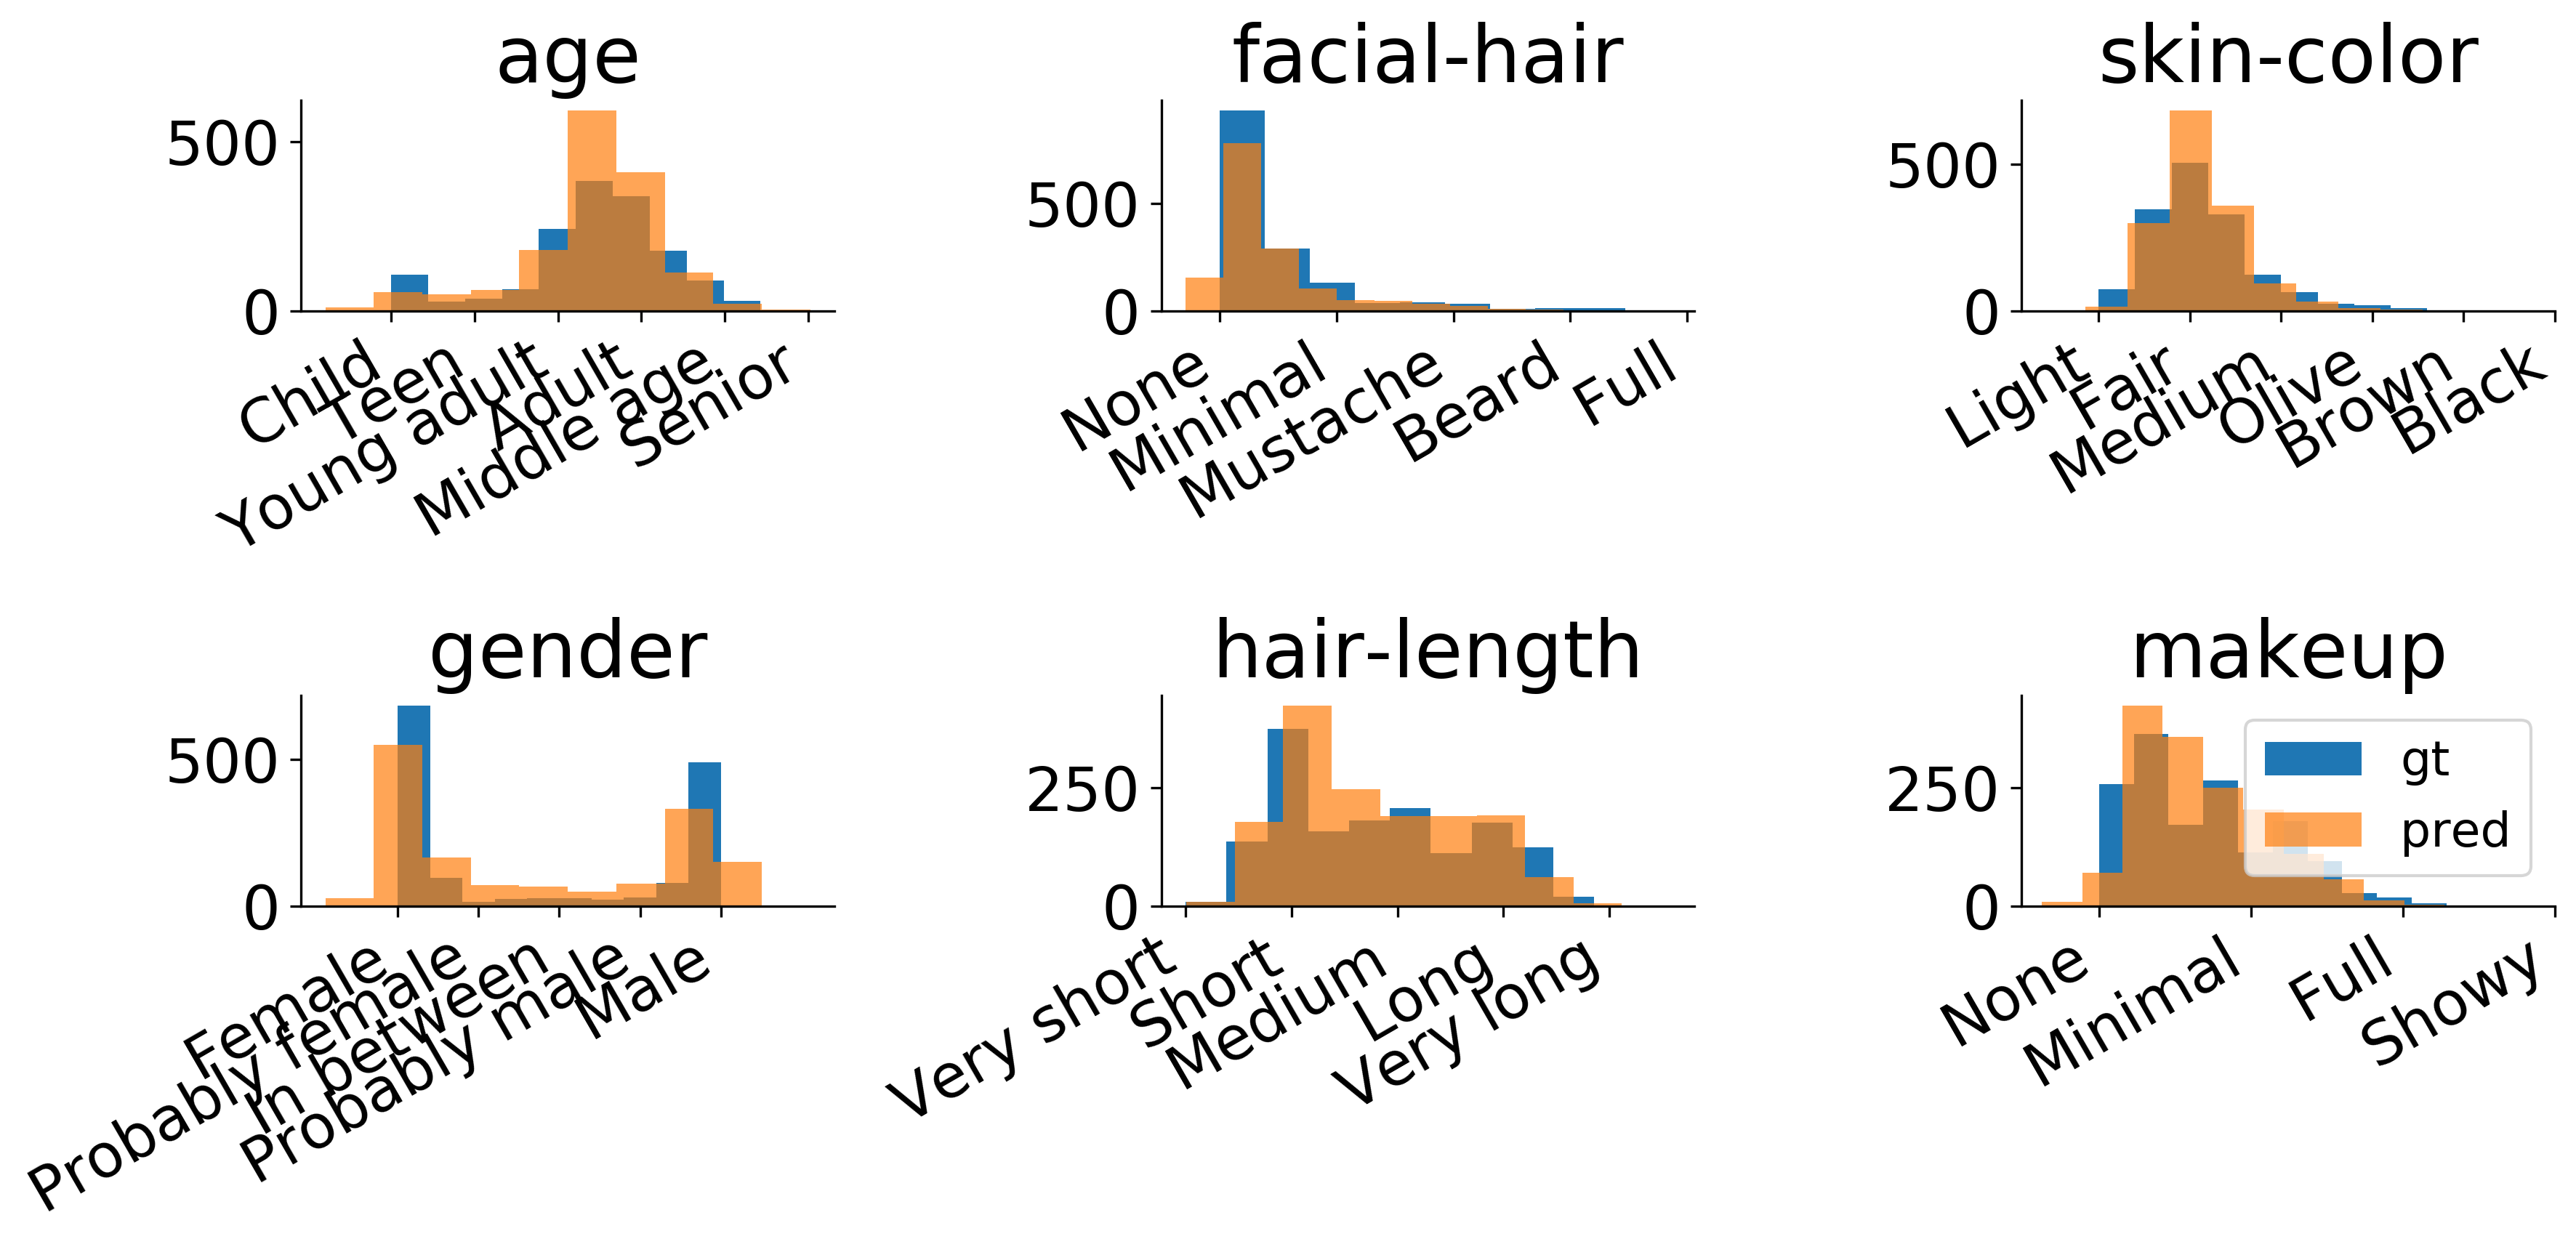

In [7]:
plt.figure(figsize=(12, 6), dpi=300)
R, C = 2, 3
for i, attr in enumerate(config.ATTRS):
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    plt.hist(y_test[:, i], label='gt')
    plt.hist(preds[:, i], alpha=0.7, label='pred')
    labs = annotations_dict_names[attr]
    plt.xticks(range(len(labs)), labs, rotation=30, ha='right')
plt.legend()
plt.tight_layout()

**pick bounds**

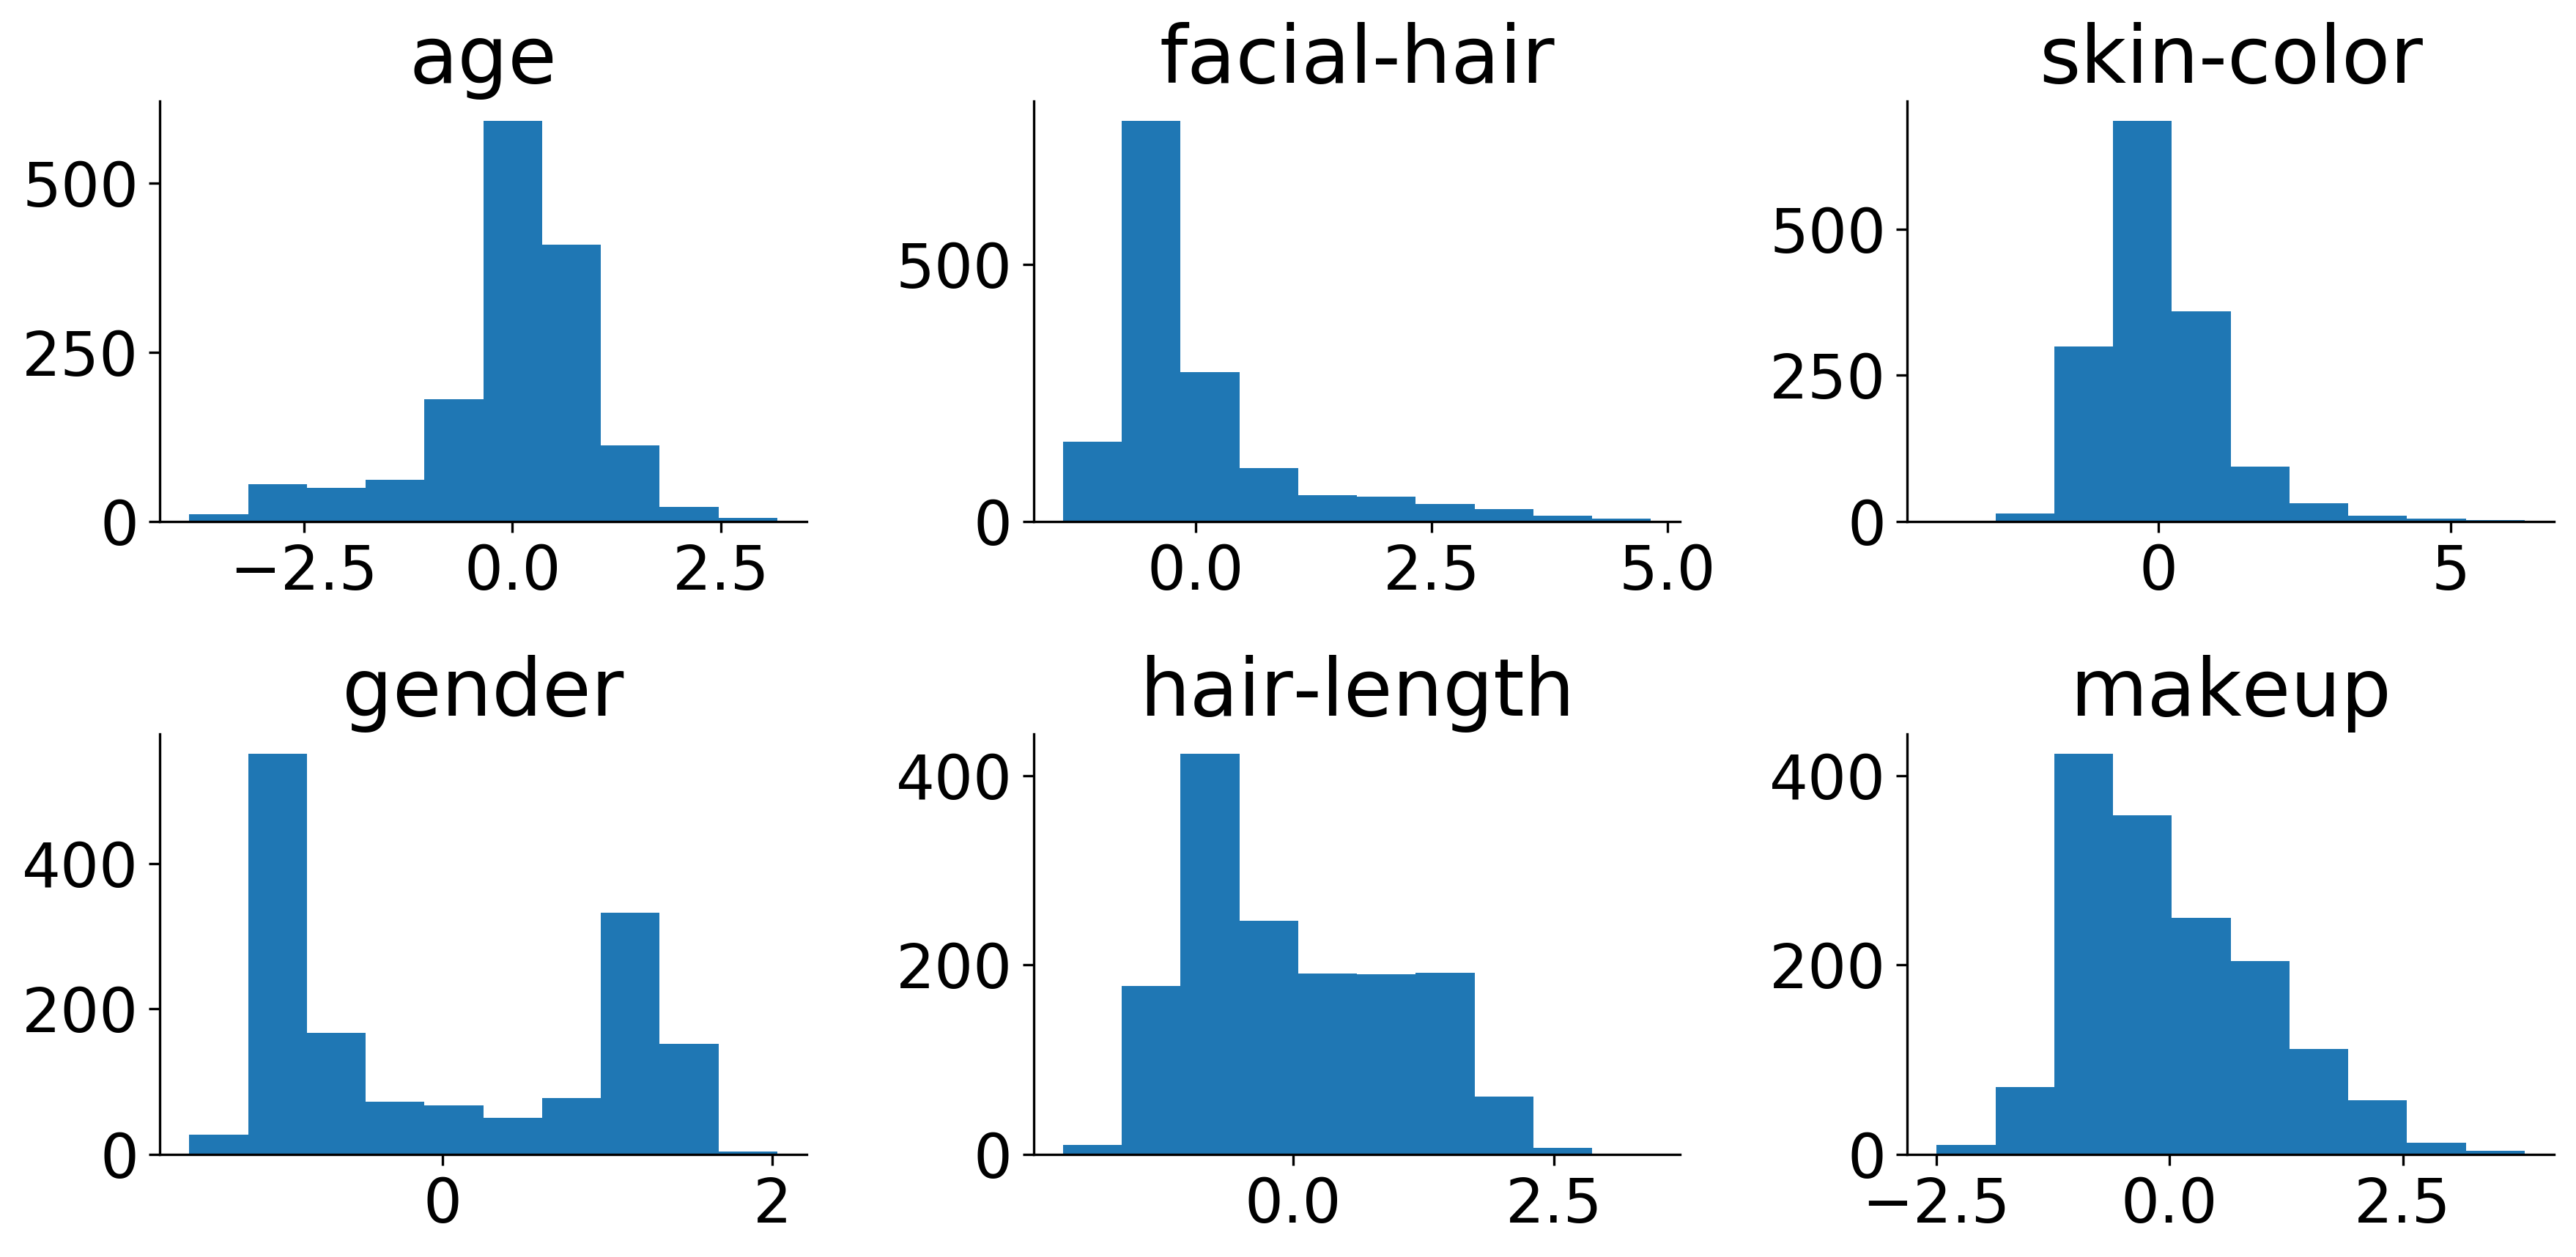

In [6]:
plt.figure(figsize=(12, 6), dpi=300)
R, C = 2, 3
preds = normalize_mat(preds)

for i, attr in enumerate(config.ATTRS):
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    plt.hist(preds[:, i])
    labs = annotations_dict_names[attr]
#     plt.xticks(range(len(labs)), labs, rotation=30, ha='right')
plt.tight_layout()

**spearman corr instead of mse okay??**

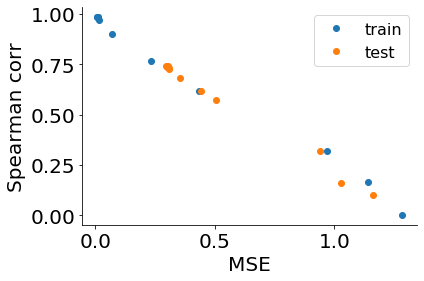

In [9]:
df = pd.read_pickle(oj(config.PROCESSED_DIR, config.BEST_MODEL + '.pkl'))
plt.plot(df['mse'], df['spearman'], 'o', label='train')
plt.plot(df['mse_test'], df['spearman_test'], 'o', label='test')
# plt.xlim((0, 0.6))
# plt.ylim((0.5, 1.0))
plt.xlabel('MSE')
plt.ylabel('Spearman corr')
plt.legend()
plt.show()

**look at correlations between predictions**

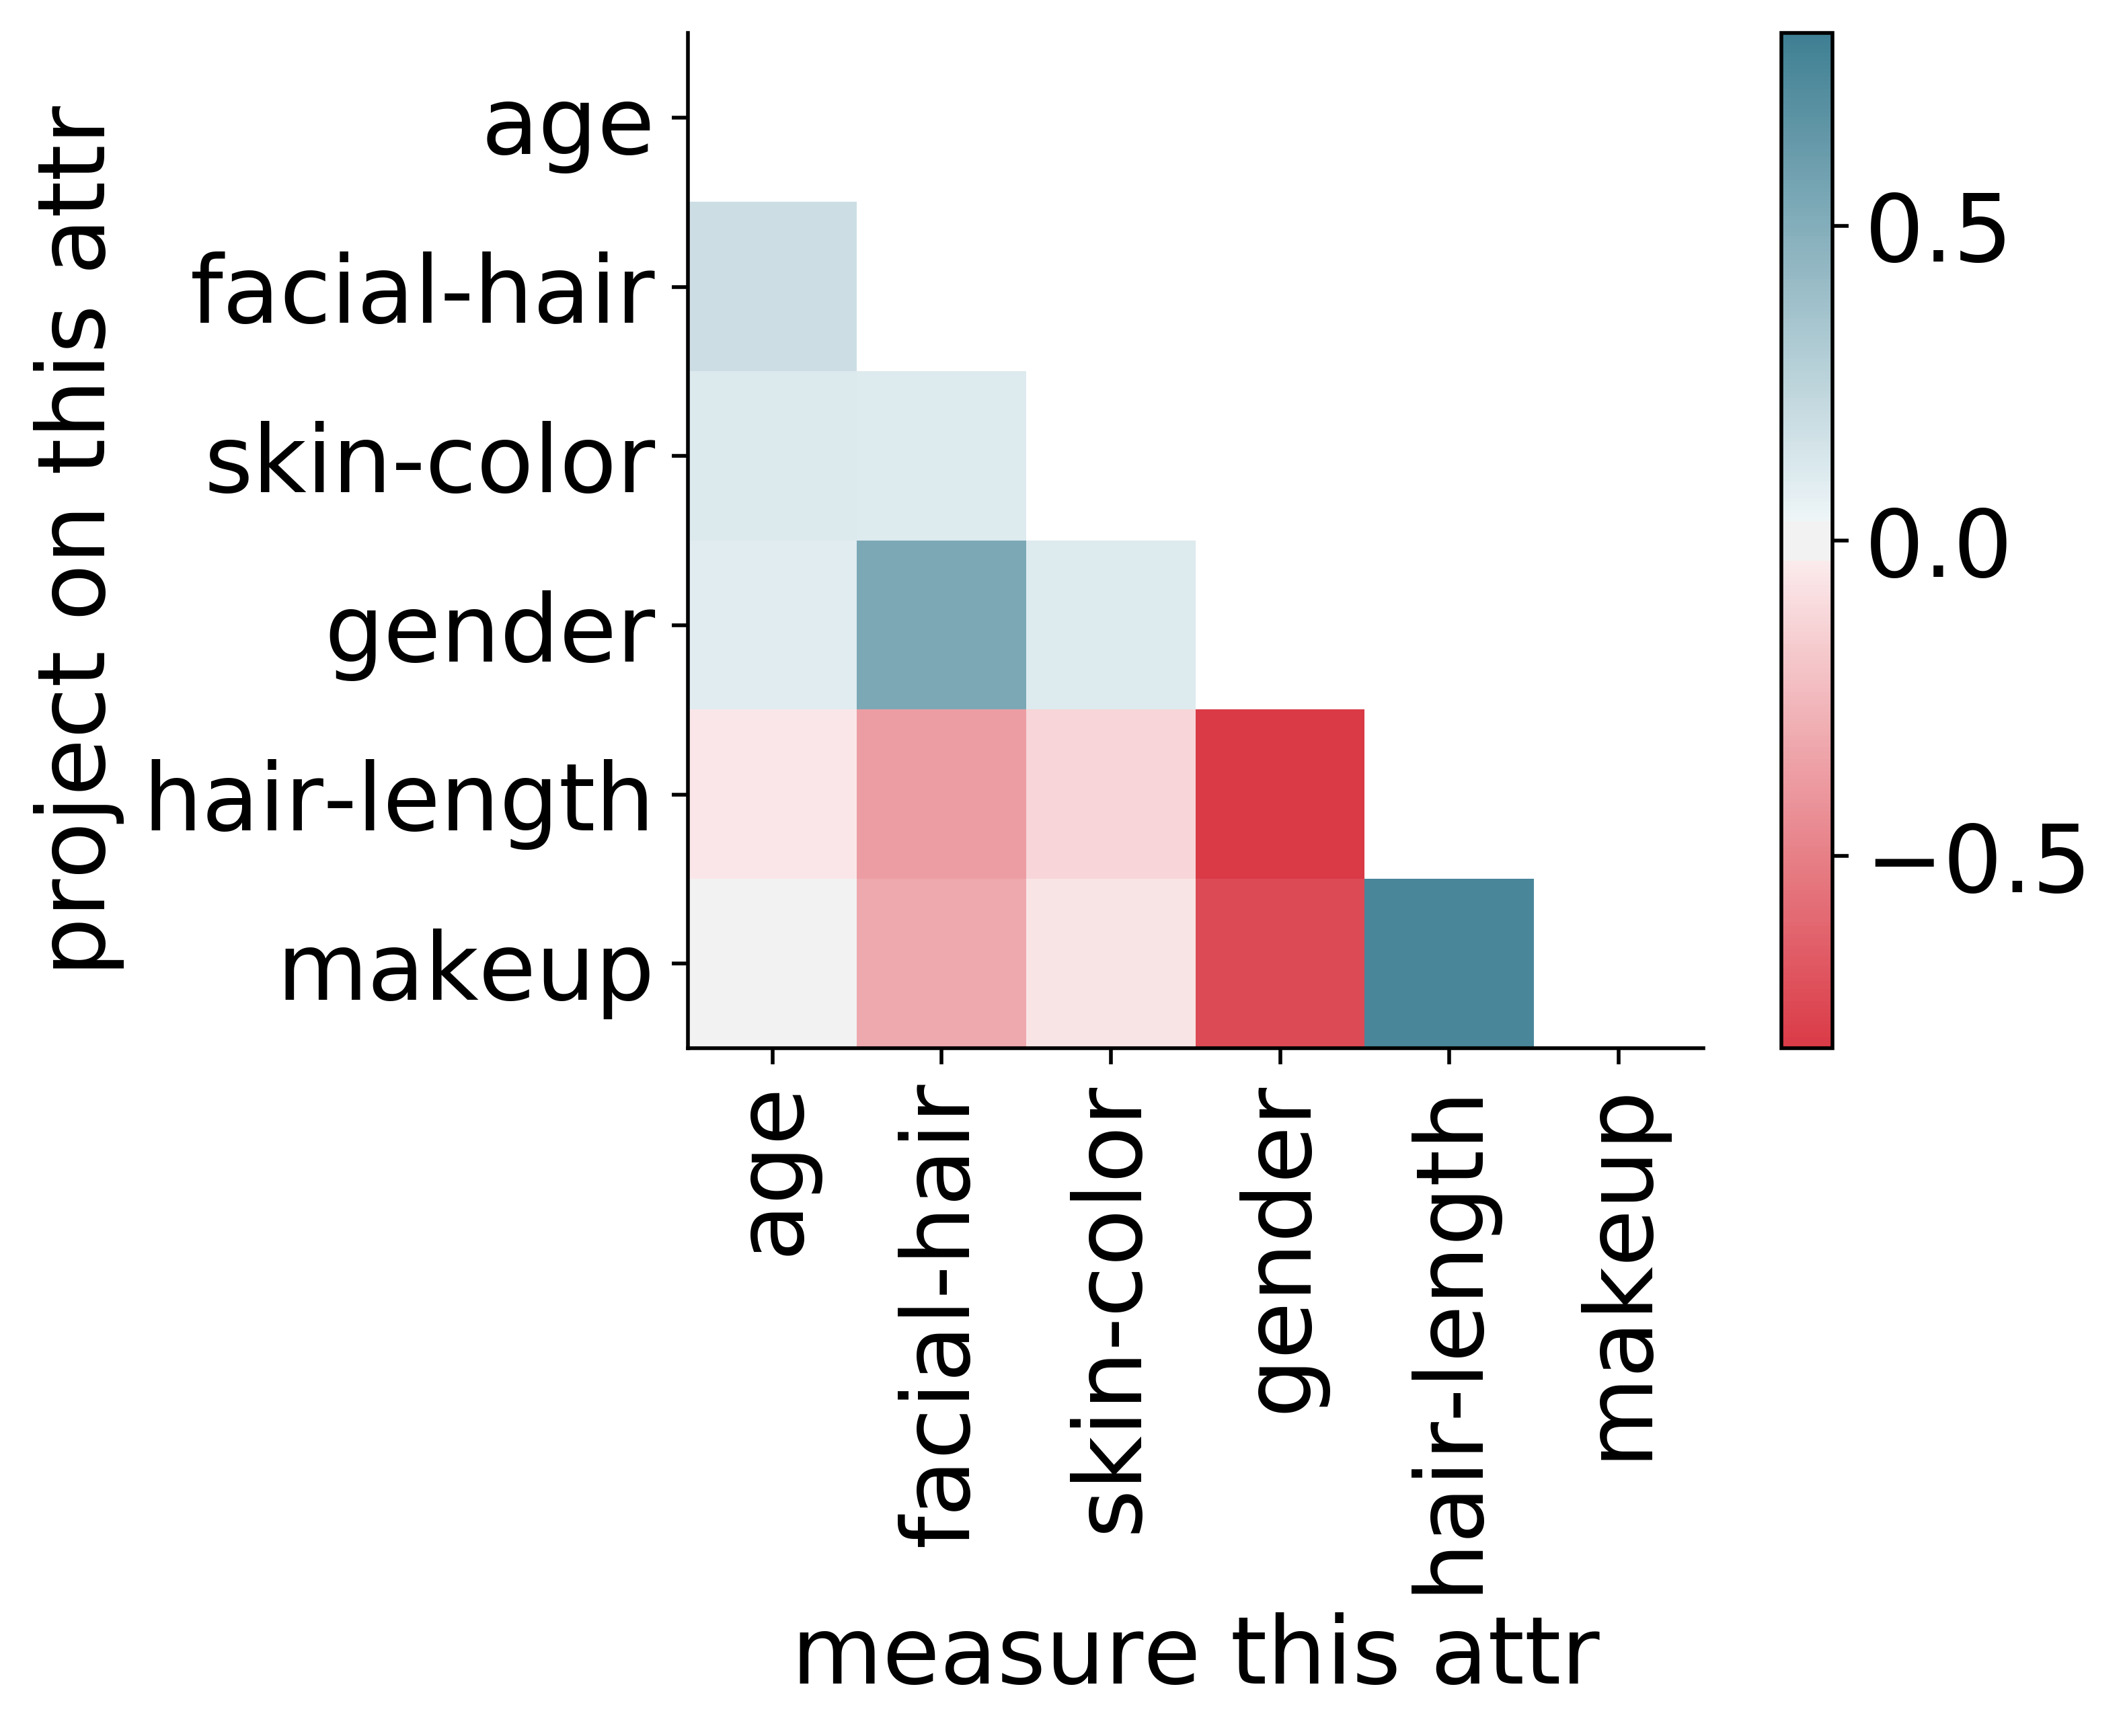

In [11]:
plt.figure(dpi=500)
viz.corrplot(np.corrcoef(preds.transpose()))
plt.xticks(range(N_A), config.ATTRS, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N_A), config.ATTRS)
plt.colorbar()
plt.show()

**more detailed**

0.8084322187819931
0.4926576239439074
0.5896175665426479
0.8657855421559619
0.8813003460510301
0.7197700569085026


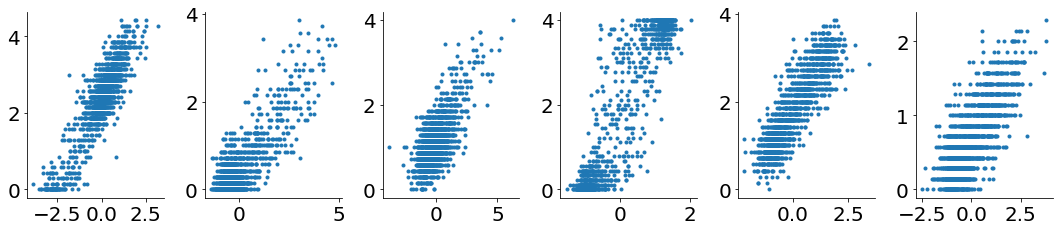

In [40]:
R, C = 1, 6
plt.figure(figsize=(15, 3.5))
for i in range(6):
    plt.subplot(R, C, i + 1)
    plt.plot(preds[:, i], y_test[:, i], '.')
    plt.xlabel(f'preds {}')
    print(scipy.stats.spearmanr(preds[:, i], y_test[:, i]).correlation)

plt.tight_layout()
plt.show()